# Learning forcing terms for SPDE
Wave SPDE from "Numerical solution of the (stochastic) wave equation"
from JOHN B. WALSH, see: https://www.math.ubc.ca/~walsh/waveq.pdf

### Define stochastic wave equation:

$$
\frac{\partial^2 u}{\partial t^2}=\frac{\partial^2 u}{\partial x^2}+f(x,t,u)+g(x,t,u)\dot{W},\ x\in\mathbb{R}, t\in\mathbb{R}^+,
$$

$$
u(x,0)=u_0(x),\ \frac{\partial u}{\partial t}(x,0)=v_0(x),\ x\in\mathbb{R}.
$$

Here, $f$ is the deterministic and $g$ the stochastic forcing term. We show how to learn these from SPDE data.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from time import time as measure_time
import os
script_dir = os.getcwd()

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

from sde.spde_utils import SPDEUtils
import tensorflow as tf

from sde.SDE_AM_lib_noLA import (
    SDEAMTrain,
    NNHyperparameters,
    MeanMinLoss
)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# Define example parameters
random_seed = 2
step_size = 1e-3
space_size = 1
time_size = 2
space = np.arange(int(space_size/step_size))*step_size
time = np.arange(int(time_size/step_size))*step_size

g_constant = 0.05

# these are the forcing terms we want to learn
f = lambda x, t, u: np.sin(4*np.pi*x) * 5
g = lambda x, t, u: g_constant * (1 + np.exp(-(x-space_size/2)**2 * 150))

# network parameters
step_size_network = step_size   # step size used in training. May be different from the SPDE size.

n_layers = 2
n_dim_per_layer = 50

n_dimensions = 1

ACTIVATIONS = tf.nn.elu
VALIDATION_SPLIT = .1
BATCH_SIZE = 512
N_EPOCHS = 100

# only diagonal diffusivity matrix (does not matter since we are in 1D)
diffusivity_type = "diagonal"

tf.random.set_seed(random_seed)

In [15]:
# define the example data
u0 = np.zeros((len(space),)) + np.sin(2*np.pi*space) * 0 + np.exp(-(space-space_size/2)**2 * 150)/20
v0 = np.zeros((len(space),))
v0 = -np.gradient(u0, step_size)*2  # define initial velocity such that the wave moves to the right


def compute_example(*args, **kwargs):
    ut = SPDEUtils.integrate_stochastic_wave(*args, **kwargs)
    return ut


def plot_example(ut):
    fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)

    im1 = ax.imshow(ut, extent=[np.min(space), np.max(space), np.min(time), np.max(time)], origin='lower')#, vmin=-1, vmax=1)
    ax.set_xlabel('Space')
    ax.set_ylabel('Time')
    fig.colorbar(im1, cax=cax, orientation='vertical')
    fig.tight_layout()

    #fig.savefig('figures/example7_data.pdf')
    #fig.savefig('figures/example7_data.png')

    fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    ax.plot(ut[0:(len(time)//5):(len(time)//5//5), :].T)
    #ax[1].set_xlim([0, 500])
    fig.tight_layout()

Data ut shape: (2000, 500)


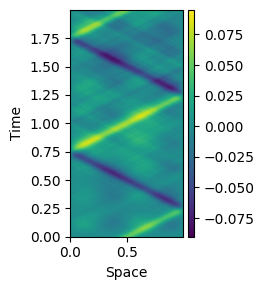

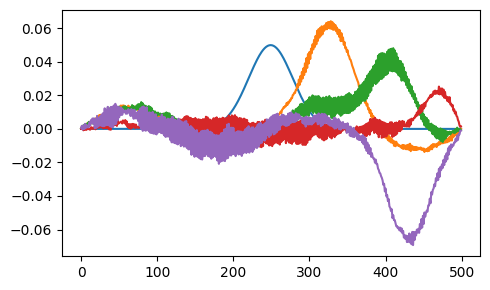

In [16]:
# Test on simple example with periodic boundaries
ut = compute_example(u0, v0, f, g, time, space, random_seed=random_seed, periodic_boundary=False);
print('Data ut shape:', ut.shape)
plot_example(ut)

In [17]:
if False:
    fig, ax = plt.subplots(figsize=(4, 2))
    ax.set_xlim((np.min(space), np.max(space)))
    ax.set_ylim((np.min(ut) * 1.1, np.max(ut) * 1.1))
    ax.set_xlabel('Space')
    ax.set_ylabel('Solution')
    ax_title = ax.set_title(f't={0:0.3f}')
    line, = ax.plot([], [], lw=.5)
    n_frames = 300

    def animate(k):
        idx = int((k * ut.shape[0] // n_frames)) % ut.shape[0]
        line.set_data(space[::2], ut[idx, :])
        ax.set_title(f't={time[k]:0.3f}')
        return (line, )


    def init():
        line.set_data([], [])
        return (line, )


    # create animation using the animate() function with no repeat
    myAnimation = animation.FuncAnimation(fig, animate, frames=n_frames,
                                          interval=10, blit=True,
                                          repeat=False)

    # save animation at 30 frames per second
    myAnimation.save('figures/myAnimation.gif', writer='pillow', fps=30, dpi=150)

    animate(1)

In [18]:
# split the data into the stencil, and reformulate the numerical scheme such that it turns into the default SDE form:
# u_np1 = u_n + f(u_n) + g(u_n) * dW
# we need to sample the space at every other point because the solution is also given on a staggered grid.
u_n, p_n, u_np1 = SPDEUtils.split_forced_wave_spde_data(ut, space[::2], time, step_size)

#p_n = p_n[:,1].reshape(-1,1)

print('u_n', u_n.shape)
print('p_n', p_n.shape)
print('u_np1', u_np1.shape)

u_n (995004, 1)
p_n (995004, 2)
u_np1 (995004, 1)


## Learn the forcing terms
Now that the data is prepared, we can use the normal SDE learning framework to extract the forcing terms.

In [32]:
print(p_n)

[[1.000e-03 2.000e-03]
 [1.000e-03 4.000e-03]
 [1.000e-03 6.000e-03]
 ...
 [1.998e+00 9.920e-01]
 [1.998e+00 9.940e-01]
 [1.998e+00 9.960e-01]]


In [20]:
# network parameters
validation_split = .1
AM_validation_split = .1

drift_param = NNHyperparameters(K=2**7, 
                                M_min=30,
                                M_max=300,
                                gamma=1,
                                delta=0.2,
                                name='drift')
diff_param = NNHyperparameters(K=drift_param.K,
                               M_min=drift_param.M_min,
                               M_max=drift_param.M_max,
                               gamma=drift_param.gamma,
                               delta=0.4,
                               name='diff')



In [40]:
def true_drift(x):
    x = np.atleast_2d(x)
    x = x[:,1]
    return (np.sin(4*np.pi*x) * 5).reshape(-1, 1)


def true_diffusivity(x):
    x = np.atleast_2d(x)
    x = x[:,1]
    return g_constant * (1 + np.exp(-(x-space_size/2)**2 * 150)).reshape(-1, 1, 1)
    

def true_drift_diffusivity(t, x):
    return true_drift(x), true_diffusivity(x)

# random_indices = np.random.choice(u_n.shape[0], 100000, replace=False)

# u_n = u_n[random_indices, :]
# u_np1 = u_np1[random_indices, :]
# p_n = p_n[random_indices, :]

step_sizes = np.zeros((u_n.shape[0],)) + step_size


In [41]:
def get_loss(y_n, y_np1, x, step_sizes, diff_type="diagonal"):

    #drift_ = SAT.drift(x)
    #diffusivity_ = np.sqrt(step_size ** 2 / step_size * 2) * SAT.diff(x)
    drift_ = true_drift(x)
    diffusivity_ = true_diffusivity(x)

    loc = y_n + step_sizes * drift_
    scale = np.sqrt(0.5) * diffusivity_
    if diff_type == "spd":
        scale = tf.linalg.matmul(scale, tf.linalg.matrix_transpose(scale))
        scale = tf.linalg.cholesky(scale)
    
    loc = tf.convert_to_tensor(loc, dtype=tf.float64)
    scale = tf.convert_to_tensor(scale, dtype=tf.float64)
    
    if diff_type == "diagonal":
        approx_normal = tfd.MultivariateNormalDiag(
            loc=loc,
            scale_diag=np.diagonal(scale, axis1=1, axis2=2),
            name="approx_normal"
        )
    else:
        approx_normal = tfd.MultivariateNormalTriL(
            loc=loc,
            scale_tril=scale,
            name="approx_normal"
        )

    log_prob = approx_normal.log_prob(y_np1)
    sample_distortion = -tf.reduce_mean(log_prob, axis=-1)
    distortion = tf.reduce_mean(sample_distortion)

    additive_constant = 0
    loss = distortion + additive_constant
    return loss

random_indices = np.random.choice(u_n.shape[0], 100000, replace=False)
u_n_loss2 = u_n[random_indices, :]
u_np1_loss2 = u_np1[random_indices, :]
p_n_loss2 = p_n[random_indices, :]
step_sizes_loss2 = step_sizes[random_indices].reshape(-1, 1)

print(get_loss(u_n_loss2, u_np1_loss2, p_n_loss2, step_sizes_loss2))

tf.Tensor(-1.8101038089598818, shape=(), dtype=float64)


In [42]:
def get_loss(y_n, y_np1, x, step_sizes, diff_type="diagonal"):

    drift_ = SAT.drift(x)
    diffusivity_ = np.sqrt(step_size ** 2 / step_size * 2) * SAT.diff(x)
    #drift_ = true_drift(x)
    #diffusivity_ = true_diffusivity(x)

    loc = y_n + step_sizes * drift_
    scale = np.sqrt(0.5) * diffusivity_
    if diff_type == "spd":
        scale = tf.linalg.matmul(scale, tf.linalg.matrix_transpose(scale))
        scale = tf.linalg.cholesky(scale)
    
    loc = tf.convert_to_tensor(loc, dtype=tf.float64)
    scale = tf.convert_to_tensor(scale, dtype=tf.float64)
    
    if diff_type == "diagonal":
        approx_normal = tfd.MultivariateNormalDiag(
            loc=loc,
            scale_diag=np.diagonal(scale, axis1=1, axis2=2),
            name="approx_normal"
        )
    else:
        approx_normal = tfd.MultivariateNormalTriL(
            loc=loc,
            scale_tril=scale,
            name="approx_normal"
        )

    log_prob = approx_normal.log_prob(y_np1)
    sample_distortion = -tf.reduce_mean(log_prob, axis=-1)
    distortion = tf.reduce_mean(sample_distortion)

    additive_constant = 0
    loss = distortion + additive_constant
    return loss

In [44]:
xlim = np.array([[0, time_size], [0, space_size]])
MML = MeanMinLoss()
mean_loss, SD, SD_val = MML.get_MML(true_diffusivity, n_dimensions, u_n.shape[0], validation_split, xlim, step_size, input_dimensions=2)
print('Theoretical mean min loss:', mean_loss)
print('Loss standard deviation:', SD)
print('Validation loss standard deviation:', SD_val)

# output_dir = os.path.join(script_dir, 'loss_data')
# output_path = os.path.join(output_dir, "TMLE ex7 - Wave SPDE.txt")
# with open(output_path, 'w') as file:
#     file.write(f"{mean_loss}\n")

Theoretical mean min loss: -4.919939110452292
Loss standard deviation: 0.0007472248974789504
Validation loss standard deviation: 0.0022416746924368513


In [46]:
No_of_tests = 1
training_time = np.zeros(No_of_tests)
val_loss = np.zeros(No_of_tests)

for i in range(No_of_tests):
    SAT = SDEAMTrain(n_dimensions=n_dimensions)
    hist = SAT.train_model(drift_param, diff_param, true_drift, true_diffusivity, u_n, u_np1, p_n, step_sizes=step_sizes, validation_split=validation_split, AM_validation_split=AM_validation_split, XinY=False, plot=True)
    training_time[i] = hist.history["training_time"]
    
    random_indices = np.random.choice(u_n.shape[0], 100000, replace=False)
    u_n_loss = u_n[random_indices, :]
    u_np1_loss = u_np1[random_indices, :]
    p_n_loss = p_n[random_indices, :]
    step_sizes_loss = step_sizes[random_indices].reshape(-1, 1)
    val_loss[i] = get_loss(u_n_loss, u_np1_loss, p_n_loss, step_sizes_loss)

drift epoch: 71
diff epoch: 99
Observed loss: -1.8122772268773304
Observed validation loss: -1.811853364805069
True function validation loss: 244.71611945583297
Training time: 2497.3638813495636


/home/douglaoj/miniconda3/envs/SDE_NN/lib/python3.9/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/douglaoj/miniconda3/envs/SDE_NN/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/douglaoj/miniconda3/envs/SDE_NN/lib/python3.9/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/douglaoj/miniconda3/envs/SDE_NN/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1066: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
/home/douglaoj/miniconda3/envs/SDE_NN/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1067: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])
/home/douglaoj/miniconda

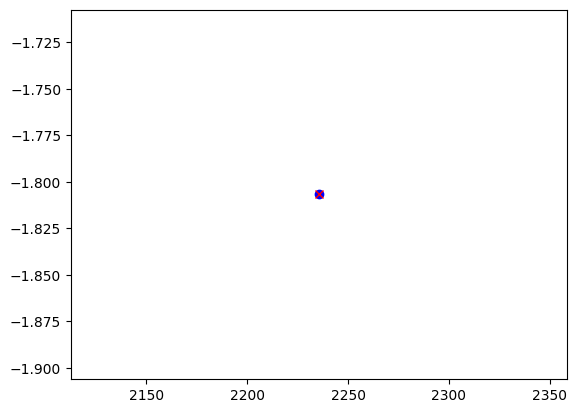

In [13]:
# Calculate the mean
mean_training_time = np.mean(training_time)
mean_val_loss = np.mean(val_loss)

# Calculate the standard deviation above and below the mean for training_time
training_time_above = training_time[training_time > mean_training_time] - mean_training_time
training_time_below = mean_training_time - training_time[training_time < mean_training_time]

std_training_time_above = np.std(np.concatenate((training_time_above, -training_time_above)))
std_training_time_below = np.std(np.concatenate((training_time_below, -training_time_below)))

# Calculate points above and below the mean for val_loss
val_loss_above = val_loss[val_loss > mean_val_loss] - mean_val_loss
val_loss_below = mean_val_loss - val_loss[val_loss < mean_val_loss]

std_val_loss_above = np.std(np.concatenate((val_loss_above, -val_loss_above)))
std_val_loss_below = np.std(np.concatenate((val_loss_below, -val_loss_below)))

# Plot scatter points
plt.scatter(training_time, val_loss, color='blue', label='Data Points')

# Add non-symmetrical error bars (standard deviations)
plt.errorbar(
    mean_training_time, mean_val_loss,
    xerr=[[std_training_time_below], [std_training_time_above]],  # Non-symmetrical x error
    yerr=[[std_val_loss_below], [std_val_loss_above]],  # Non-symmetrical y error
    fmt='x', color='red', ecolor='black', elinewidth=1.5, capsize=4, label='Mean ± STD'
)
plt.show()

# output_dir = os.path.join(script_dir, 'loss_data')
# output_path = os.path.join(output_dir, "ex7 - Wave SPDE.txt")
# with open(output_path, 'w') as file:
#     file.write(f"{mean_training_time},{mean_val_loss},{std_training_time_above},{std_training_time_below},{std_val_loss_above},{std_val_loss_below}\n")


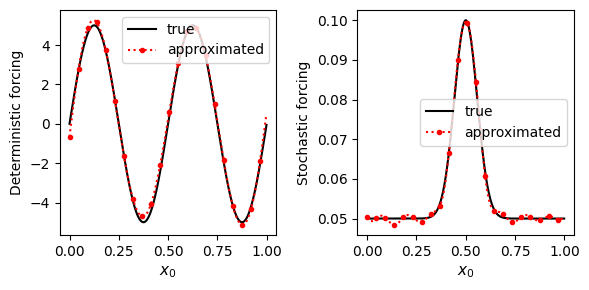

In [26]:
# visualize the results against the true forcing functions

def plot_forcings_space(ut):
    fig, ax = plt.subplots(1, 2, figsize=(6, 3))

    f_true = f(space, time[0], ut[0, :])
    g_true = g(space, time[0], ut[0, :])
    state_k = np.array([ut[0, :]]).reshape(-1, 1)*1
    param_k = np.zeros((ut.shape[1], 2))
    param_k[:, 0] = time[0]
    param_k[:, 1] = space[::2]
    f_approx = SAT.drift(space[::2].reshape(-1,1))
    #model_f, model_g = model.call_xn(state_k, param_xn=param_k)
    #f_approx = tf.keras.backend.eval(model_f).ravel()

    # this is an important scaling here, as from the SDE formulation to the SPDE formulation we loose the factor sqrt(2 h^2 / h)
    #g_approx = np.sqrt(step_size ** 2 / step_size * 2) * tf.keras.backend.eval(model_g).ravel()
    g_approx = np.sqrt(step_size ** 2 / step_size * 2) *SAT.diff(space[::2].reshape(-1,1))
    
    ax[0].plot(space, f_true, "-", color="black", label="true")
    ax[0].plot(space[::2], f_approx, ".:", markevery=len(space)//42, color="red", label="approximated")
    ax[0].set_xlabel(r'$x_0$', fontsize=11)
    ax[0].set_ylabel('Deterministic forcing')
    ax[0].legend(loc='upper right')

    ax[1].plot(space, g_true, "-", color="black", label="true")
    ax[1].plot(space[::2], g_approx.reshape(param_k.shape[0], 1), ".:", markevery=len(space)//42, color="red", label="approximated")
    ax[1].set_xlabel(r'$x_0$', fontsize=11)
    ax[1].set_ylabel('Stochastic forcing')
    ax[1].legend(loc='right')

    fig.tight_layout()

    # fig.savefig('figures/example7_wave_spde_forcings.pdf')
    # fig.savefig('figures/example7_wave_spde_forcings.png')

    output_dir = os.path.join(script_dir, 'trained_vs_true_plots')
    output_path = os.path.join(output_dir, "ex7 - Wave SPDE")
    fig.savefig(output_path, dpi=300, bbox_inches='tight')


def plot_forcings(ut):
    fig, ax = plt.subplots(1, 4, figsize=(15, 3))
    divider1 = make_axes_locatable(ax[0])
    divider2 = make_axes_locatable(ax[1])
    divider3 = make_axes_locatable(ax[2])
    divider4 = make_axes_locatable(ax[3])
    cax1 = divider1.append_axes('right', size='5%', pad=0.05)
    cax2 = divider2.append_axes('right', size='5%', pad=0.05)
    cax3 = divider3.append_axes('right', size='5%', pad=0.05)
    cax4 = divider4.append_axes('right', size='5%', pad=0.05)

    f_true = np.zeros((len(time), len(space)))
    g_true = np.zeros((len(time), len(space)))
    f_approx = np.zeros((len(time), len(space)//2))
    g_approx = np.zeros((len(time), len(space)//2))
    for k in range(len(time)):
        f_true[k, :] = f(space, time[k], ut[k, :])
        g_true[k, :] = g(space, time[k], ut[k, :])
        state_k = np.array([ut[k, :]]).reshape(-1, 1)*1
        param_k = np.zeros((ut.shape[1], 2))
        param_k[:, 0] = time[k]
        param_k[:, 1] = space[::2]
        #model_f, model_g = model.call_xn(state_k, param_xn=param_k)
        #f_approx[k, :] = tf.keras.backend.eval(model_f).ravel()
        f_approx = SAT.drift(space[::2].reshape(-1,1))

        # this is an important scaling here, as from the SDE formulation to the SPDE formulation we loose the factor sqrt(2 h^2 / h)
        #g_approx[k, :] = np.sqrt(step_size ** 2 / step_size * 2) * tf.keras.backend.eval(model_g).ravel()
        g_approx = 2*SAT.diff(space[::2].reshape(-1,1))

    im1 = ax[0].imshow(f_true, extent=[np.min(space), np.max(space), np.min(time), np.max(time)], origin='lower')#, vmin=-20, vmax=20)
    ax[0].set_xlabel('Space')
    ax[0].set_ylabel('Time')
    fig.colorbar(im1, cax=cax1, orientation='vertical')

    im2 = ax[1].imshow(f_approx, extent=[np.min(space), np.max(space), np.min(time), np.max(time)], origin='lower')#, vmin=-20, vmax=20)
    ax[1].set_xlabel('Space')
    ax[1].set_ylabel('Time')
    fig.colorbar(im2, cax=cax2, orientation='vertical')

    im3 = ax[2].imshow(g_true, extent=[np.min(space), np.max(space), np.min(time), np.max(time)], origin='lower')#, vmin=-g_constant*1.5, vmax=g_constant*1.5)
    ax[2].set_xlabel('Space')
    ax[2].set_ylabel('Time')
    fig.colorbar(im3, cax=cax3, orientation='vertical')

    im4 = ax[3].imshow(g_approx, extent=[np.min(space), np.max(space), np.min(time), np.max(time)], origin='lower')#, vmin=-g_constant*1.5, vmax=g_constant*1.5)
    ax[3].set_xlabel('Space')
    ax[3].set_ylabel('Time')
    fig.colorbar(im4, cax=cax4, orientation='vertical')

    fig.tight_layout()


#plot_forcings_space(ut, encoder)
plot_forcings_space(ut)
#plot_forcings(ut)

## Convergence tests
Compute the error (MSE) between the true solutions and the network solutions, for increasing number of data points.

In [29]:
def train_network(n_data_points, seed=1):
    # define model
    encoder = ModelBuilder.define_gaussian_process(
                                        n_input_dimensions=n_dimensions,
                                        n_output_dimensions=n_dimensions,
                                        n_parameter_dimensions=2,
                                        n_layers=n_layers,
                                        n_dim_per_layer=n_dim_per_layer,
                                        name="SPDE_forcing",
                                        activation=ACTIVATIONS,
                                        diffusivity_type=diffusivity_type)
    # encoder.summary()

    model = SDEApproximationNetwork(sde_model=encoder,
                                    method="euler",
                                    step_size=np.array(step_size_network).astype(np.float64),
                                    n_parameters=p_n.shape[1])
    model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=1e-2))

    rng = np.random.default_rng(seed)
    idx = rng.permutation(np.arange(u_n.shape[0]))[:n_data_points]
    # train model with the specified number of data points
    u_n_i = u_n[idx, :]
    u_np1_i = u_np1[idx, :]
    p_n_i = p_n[idx, :]
    
    # number of iterations is fixed, so that we update all networks roughly the same number of times
    N_EPOCHS_i = N_EPOCHS * 500000 // n_data_points
    
    t0 = measure_time()
    sde_i = SDEIdentification(model=model)
    hist = sde_i.train_model(u_n_i.astype(np.float64), u_np1_i.astype(np.float64),
                         p_n=p_n_i.astype(np.float64),
                         validation_split=0.01,
                         n_epochs=N_EPOCHS_i,
                         batch_size=BATCH_SIZE)
    t1 = measure_time()
    
    # evaluate on grid data and compare to true functions in MSE
    f_true = f(space[::2], time[0], ut[0, ::2])
    g_true = g(space[::2], time[0], ut[0, ::2])
    state_k = np.array([ut[0, :]]).reshape(-1, 1)*1
    param_k = np.zeros((ut.shape[1], 2))
    param_k[:, 0] = time[0]
    param_k[:, 1] = space[::2]
    model_f, model_g = model.call_xn(state_k, param_xn=param_k)
    f_approx = tf.keras.backend.eval(model_f).ravel()

    # this is an important scaling here, as from the SDE formulation to the SPDE formulation we loose the factor sqrt(2 h^2 / h)
    g_approx = np.sqrt(step_size ** 2 / step_size * 2) * tf.keras.backend.eval(model_g).ravel()

    return {
        'f_true': f_true,
        'f_approx': f_approx,
        'mse_f': np.mean(np.square((f_approx - f_true))),
        'mse_g': np.mean(np.square((g_approx - g_true))),
        'loss': hist.history['loss'][-1],
        'val_loss': hist.history['val_loss'][-1],
        'n_data_points': n_data_points,
        'training_time': t1-t0
    }

In [ ]:
train_large = False # set to True if the large training experiment must be performed

In [ ]:
if train_large:
    data = []
    for k in np.linspace(3.5, 6, num=10):
        for k2 in range(10):
            data.append(train_network(int(10**k)))
    errors_df = pd.DataFrame.from_dict(data)

In [ ]:
if train_large:
    fig, ax = plt.subplots(1, 3, figsize=(10, 3))

    def plot_error(ax, y, label, loglog=True, ylabel='True mean squared error'):
        if loglog:
            ax.loglog(errors_df['n_data_points'], y, '.', label=label)
        else:
            ax.semilogx(errors_df['n_data_points'], y, '.', label=label)
        ax.legend() # loc='upper right')
        ax.set_xlabel('Data points')
        ax.set_ylabel(ylabel)

    plot_error(ax[0], errors_df['mse_f'], 'Drift')
    plot_error(ax[1], errors_df['mse_g'], 'Diffusivity')
    plot_error(ax[2], errors_df['loss'], 'Training set', loglog=False, ylabel='Euler-Maruyama loss')
    plot_error(ax[2], errors_df['val_loss'], 'Validation set', loglog=False, ylabel='Euler-Maruyama loss')

    fig.tight_layout()
    fig.savefig('figures/example7_wavepde_trueloss.pdf')
    fig.savefig('figures/example7_wavepde_trueloss.png')

In [ ]:
# number of weight update iterations for the convergence test:
print((N_EPOCHS * 500000 // 10**6) * (10**6 // BATCH_SIZE))